<a href="https://colab.research.google.com/github/nsedov/DLS2/blob/main/task6/part1_GPT/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.4 MB/s eta 0:00:00


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

from sklearn.metrics import accuracy_score

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [4]:
emotion_dataset = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [5]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [8]:
emotion_dataset["train"]["label"][0]

0

In [9]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [10]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [11]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [12]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [14]:
inputs = tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

In [15]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [16]:
#

In [17]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part][idx]['text']
        label = self.dataset[self.part][idx]['label']
        tokenizer_output = self.tokenizer(text)
        target = self.label2num[label]
        out = tokenizer.encode_plus(
            self.dataset[self.part][idx]["text"], 
            max_length=self.max_length, 
            padding="max_length", 
            return_tensors="pt",
        )
        
        return {
            "input_ids": out["input_ids"][0], 
            "mask": out["attention_mask"][0],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [18]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [19]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")

In [20]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size
)
valid_loader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = batch_size
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size
)

In [21]:
example = next(iter(train_loader))

In [22]:
example

{'input_ids': tensor([[   72, 42547,  1254,  ..., 50256, 50256, 50256],
         [   72,   460,   467,  ..., 50256, 50256, 50256],
         [  320, 23256,   257,  ..., 50256, 50256, 50256],
         ...,
         [   72, 15063,  1312,  ..., 50256, 50256, 50256],
         [   72,  1254,   588,  ..., 50256, 50256, 50256],
         [   72,  2540,  1719,  ..., 50256, 50256, 50256]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([0, 0, 3, 2, 3, 0, 5, 4, 1, 2, 0, 1, 3, 0, 1, 1, 0, 0, 0, 4, 3, 4, 1, 1,
         3, 0, 0, 0, 3, 1, 1, 4, 5, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 1, 2,
         1, 3, 1, 0, 3, 4, 1, 0, 0, 5, 1, 1, 1, 2, 4, 4])}

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [23]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions = True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [24]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [25]:
# example['input_ids'], example['mask']

In [26]:
# tokens = example['input_ids'].cuda() # Получи токены из датасета
# mask = example['mask'].cuda() # Получи маску из датасета

# preds = model_0(tokens, attention_mask = mask) # Посмотри на аутпут

In [27]:
# example['target']

In [28]:
# sm = nn.Softmax(dim = 1)
# torch.argmax(sm(preds['logits']), dim = 1)

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [29]:
from tqdm.notebook import tqdm


num_epochs = 10
s_m = nn.Softmax(dim = 1)
# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        tokens = batch['input_ids'].cuda() # Получи токены из датасета
        mask = batch['mask'].cuda()
        target = batch['target'].cuda()

        output = model_0(tokens, attention_mask = mask)['logits']
        
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch['input_ids'].cuda() # Получи токены из датасета
            mask = batch['mask'].cuda()
            target = batch['target'].cuda()

            output = model_0(tokens, attention_mask = mask)['logits']
            
            loss = criterion(output, target)

            valid_loss += loss.item()

            output = torch.argmax(s_m(output), dim = 1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            # print(output)
            # print(target)
            valid_acc += accuracy_score(target, output)

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.5686741642951965,Valid Loss: 1.4444509521126747,Valid Acc: 0.43896484375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.2701236052513123,Valid Loss: 1.0576841216534376,Valid Acc: 0.61279296875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.8751609263420105,Valid Loss: 0.8112988267093897,Valid Acc: 0.70068359375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5913020389080048,Valid Loss: 0.6589044146239758,Valid Acc: 0.7734375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.3952272418141365,Valid Loss: 0.59555434435606,Valid Acc: 0.80615234375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.2799247948229313,Valid Loss: 0.4568123579956591,Valid Acc: 0.84716796875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.19773296228051185,Valid Loss: 0.4275427656248212,Valid Acc: 0.86572265625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.15454420545697212,Valid Loss: 0.41543109668418765,Valid Acc: 0.87255859375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.12082282015681267,Valid Loss: 0.3843728927895427,Valid Acc: 0.88525390625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.10307655973732471,Valid Loss: 0.4084267015568912,Valid Acc: 0.8818359375


In [30]:
# Testing

test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch['input_ids'].cuda() # Получи токены из датасета
        mask = batch['mask'].cuda()

        output = model_0(tokens, attention_mask = mask)['logits']

        output = torch.argmax(s_m(output), dim = 1).cpu().detach().numpy()
        target =  batch['target'].numpy()

        test_acc += accuracy_score(target, output)

print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 0.8798828125


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [31]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [32]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [33]:
text = emotion_dataset["train"]["text"][7] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

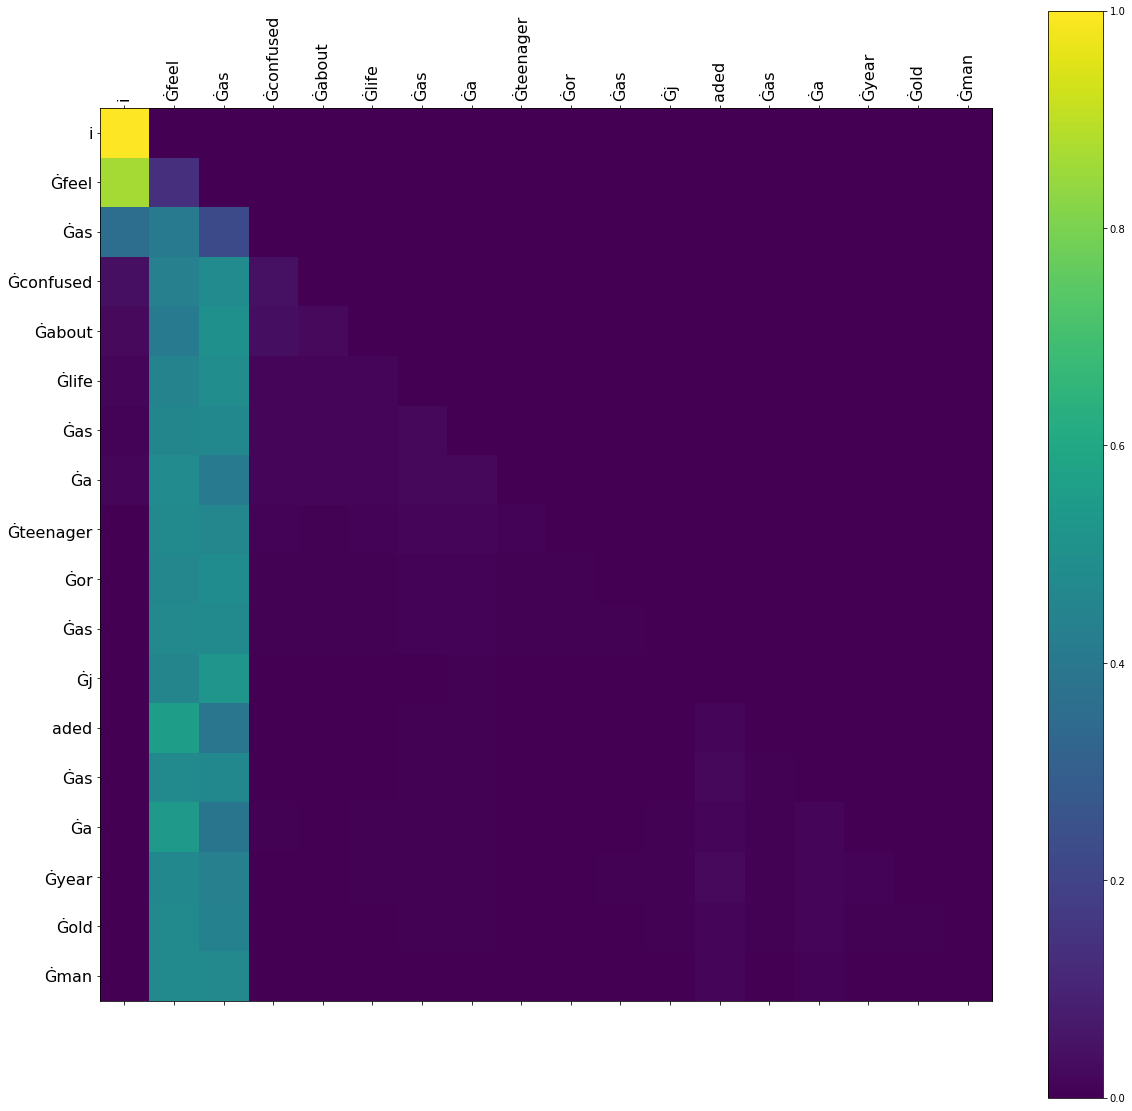

In [34]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [38]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [40]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        tokens = batch['input_ids'].cuda() # Получи токены из датасета
        mask = batch['mask'].cuda()
        target = batch['target'].cuda()

        output = model_1(tokens, attention_mask = mask)['logits']
        
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch['input_ids'].cuda() # Получи токены из датасета
            mask = batch['mask'].cuda()
            target = batch['target'].cuda()

            output = model_1(tokens, attention_mask = mask)['logits']
            
            loss = criterion(output, target)

            valid_loss += loss.item()

            output = torch.argmax(s_m(output), dim = 1).cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            # print(output)
            # print(target)
            valid_acc += accuracy_score(target, output)
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch['input_ids'].cuda() # Получи токены из датасета
        mask = batch['mask'].cuda()

        output = model_1(tokens, attention_mask = mask)['logits']

        output = torch.argmax(s_m(output), dim = 1).cpu().detach().numpy()
        target =  batch['target'].numpy()

        test_acc += accuracy_score(target, output)
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.6220178451538085,Valid Loss: 1.0845001190900803,Valid Acc: 0.60888671875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7388178670406341,Valid Loss: 0.42669934406876564,Valid Acc: 0.865234375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.3829128081202507,Valid Loss: 0.2688417478930205,Valid Acc: 0.90869140625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.26426038950681685,Valid Loss: 0.22094035940244794,Valid Acc: 0.92041015625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.19903733959794045,Valid Loss: 0.1897068398538977,Valid Acc: 0.92626953125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.17470971032977103,Valid Loss: 0.17111304425634444,Valid Acc: 0.9326171875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.15449074514210223,Valid Loss: 0.15551634971052408,Valid Acc: 0.931640625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.13885154935717584,Valid Loss: 0.1461279271170497,Valid Acc: 0.93701171875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.12535440707206727,Valid Loss: 0.1399773946031928,Valid Acc: 0.9384765625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.12008979544788599,Valid Loss: 0.13973084988538176,Valid Acc: 0.93603515625
Test Acc: 0.9248046875


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [41]:
text = emotion_dataset["train"]["text"][7] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

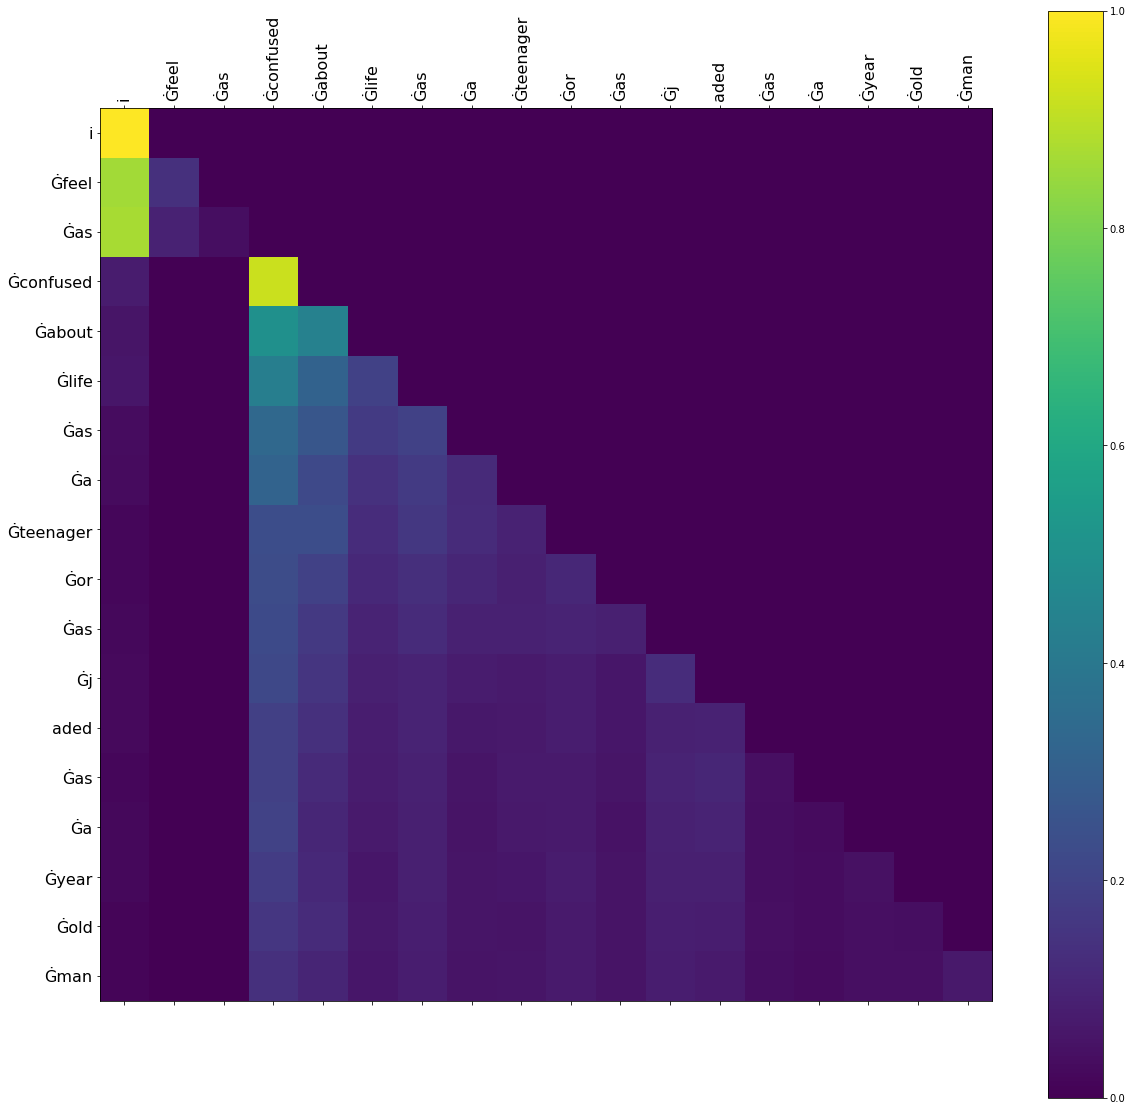

In [42]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])